In [7]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import cv2
import os
import pandas as pd
import seaborn as sns
import random

In [8]:
#Read the images and the labels from the files
folders=['BDRW_train_1/BDRW_train_1/','BDRW_train_2/BDRW_train_2/']
rd=pd.read_excel(folders[1]+'labels.xls')
X=[]
Y=[]
for folder in folders:
    images=os.listdir(folder)
    for image in images:
        img=cv2.imread(folder+image)
        if img is not None:
            img=cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)
            X.append(img)
            Y.append(rd.get_value(image[:-4],'label'))
        
BDRW_trainX= np.array(X)
BDRW_trainY=np.array(Y)
print(BDRW_trainX.shape,BDRW_trainY.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


(1393, 32, 32, 3) (1393,)


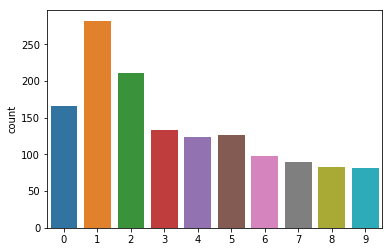

In [9]:
#Plot the count of different classes
sns.countplot(BDRW_trainY)

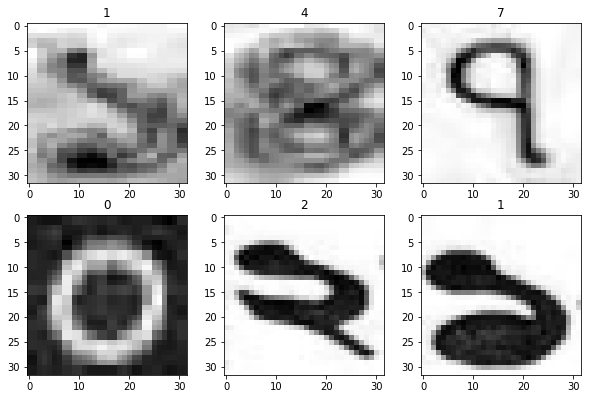

In [10]:
#show some imgaes and labels
plt.figure(figsize=(10, 10))
for i in range(0,6): # how many imgs will show from the 3x3 grid
    plt.subplot(330 + (i+1)) # open next subplot
    plt.grid(False)
    plt.imshow(BDRW_trainX[i][:,:,0], cmap=plt.get_cmap('gray'))
    plt.title(BDRW_trainY[i])

In [11]:
#Divide the data into train, cross-validation and test set randomly (60%,20% and 20% respectively)
train_ind=random.sample(range(1393), 836)
cros_val_test=[i for i in range(1393) if i not in train_ind]
cros_val= [cros_val_test[i] for i in range(len(cros_val_test)) if i%2==0]
test= [cros_val_test[i] for i in range(len(cros_val_test)) if cros_val_test[i] not in cros_val]
BDRW_trainX=np.reshape(BDRW_trainX, (1393, 3072))
X_train= BDRW_trainX[train_ind]
Y_train= BDRW_trainY[train_ind]
X_cv= BDRW_trainX[cros_val]
Y_cv= BDRW_trainY[cros_val]
X_test= BDRW_trainX[test]
Y_test= BDRW_trainY[test]
print("X_train shape:",X_train.shape)
print("Y_train shape:",Y_train.shape)

X_train shape: (836, 3072)
Y_train shape: (836,)


In [12]:
# Following is the neural net architecture
input_size = 3072
hidden_sizes = [256,128]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0],bias=True),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1],bias=True),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size,bias=True),
                      nn.LogSoftmax(dim=1))


print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [1]:
'''We now train the neural network and plot learning curves
Note:--The Class Imbalance is adjusted by attaching proper weights to the loss function'''
weights = [Y_train.shape[0]/np.sum(Y_train == i) for i in range(10)]
criterion = nn.NLLLoss(weight=torch.tensor(weights))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
time0 = time()
epochs = 15
trainLoss=[]
cvLoss=[]
for e in range(epochs):
    running_loss = 0
    ctr=1
    for images, labels in zip(X_train,Y_train):
        # Flatten MNIST images into a 784 long vector
        images= torch.from_numpy(images)
        images=images.float()
        images=images.reshape(3072,1)
        images= (images-images.mean())/(max(images)-min(images))
        # Training pass
        optimizer.zero_grad()
        output = model(images.T)
        loss = criterion(output, torch.tensor(labels).reshape(1,))        
        #This is where the model learns by backpropagating
        loss.backward()        
        #And optimizes its weights here
        optimizer.step()
        running_loss += loss.item()
        if pd.isnull(running_loss):
            print("Breaking at ",ctr)
            break
        ctr=ctr+1
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/836))
        trainLoss.append(running_loss/836)
        c1=0
        c2=0
        for images, labels in zip(X_cv,Y_cv):
            c1=c1+1
            image=torch.from_numpy(images)
            image=image.float()
            image=image.reshape(3072,1)
            image=(image-image.mean())/(max(image)-min(image))
            logsp=model(image.T)
            p_max, dig= logsp.max(1)
            if int(dig)==labels:
                c2=c2+1
        cvLoss.append(c2/c1)

print("\nTraining Time (in minutes) =",(time()-time0)/60)

NameError: name 'Y_train' is not defined

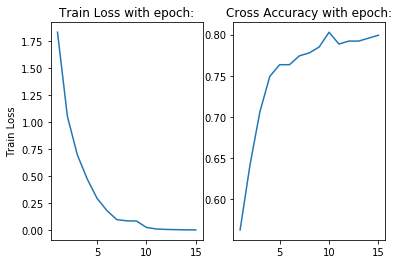

In [17]:
plt.subplot(1,2,1)
x=range(1, len(trainLoss)+1)
y=trainLoss
plt.plot(x,y)
plt.title("Train Loss with epoch:")
plt.ylabel("Train Loss")
plt.subplot(1,2,2)
plt.title("Cross Accuracy with epoch:")

x=range(1, len(cvLoss)+1)
y=cvLoss
plt.plot(x,y)

In [15]:
for image, label in zip(X_cv,Y_cv):
    image= torch.from_numpy(image)
    image=image.float()
    model=model.float()
    image=image.reshape(3072,1)
    image =(image-image.mean())/(max(image)-min(image))
    logsp = model(image.T)  
    ps = torch.exp(logsp)
    p_max, dig= ps.max(1)
    print("Predicted Digit =", int(dig), end=" ")
    print("label:",label)   

Predicted Digit = 5 label: 1
Predicted Digit = 0 label: 0
Predicted Digit = 2 label: 2
Predicted Digit = 5 label: 5
Predicted Digit = 7 label: 7
Predicted Digit = 3 label: 1
Predicted Digit = 6 label: 1
Predicted Digit = 3 label: 3
Predicted Digit = 2 label: 2
Predicted Digit = 6 label: 6
Predicted Digit = 2 label: 2
Predicted Digit = 1 label: 1
Predicted Digit = 3 label: 3
Predicted Digit = 7 label: 7
Predicted Digit = 9 label: 9
Predicted Digit = 4 label: 4
Predicted Digit = 0 label: 0
Predicted Digit = 1 label: 1
Predicted Digit = 6 label: 0
Predicted Digit = 8 label: 0
Predicted Digit = 0 label: 0
Predicted Digit = 0 label: 0
Predicted Digit = 4 label: 4
Predicted Digit = 1 label: 9
Predicted Digit = 4 label: 4
Predicted Digit = 5 label: 5
Predicted Digit = 5 label: 5
Predicted Digit = 4 label: 4
Predicted Digit = 1 label: 1
Predicted Digit = 0 label: 0
Predicted Digit = 3 label: 0
Predicted Digit = 7 label: 0
Predicted Digit = 0 label: 0
Predicted Digit = 1 label: 1
Predicted Digi

In [18]:
c1=0
c2=0
for images, labels in zip(X_test,Y_test):
    c1=c1+1
    image=torch.from_numpy(images)
    image=image.float()
    image=image.reshape(3072,1)
    image=(image-image.mean())/(max(image)-min(image))
    logsp=model(image.T)
    p_max, dig= logsp.max(1)
    if int(dig)==labels:
        c2=c2+1
print("Test accuracy of the trained model is %f percent"%(c2/c1*100))


Test accuracy of the trained model is 78.417266 percent
